# Mixing in the magnetic field of the Milky Way

This tutorial demonstrates mixing in the Galactic mangetic field (GMF) of the Milky Way. 
The GMF will be modeled here through the model of the coherent component put forward by <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...757...14J/abstract">Jansson & Farrar (2012)</a>.

In addition to the simple photon-ALP oscillation calculation as a function of energy also shown in the other tutorials, here we also demonstrate how one can extract the mixing as a function of propagation distance, which nicely demonstrates the effect of the different B-field components of the <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...757...14J/abstract">Jansson & Farrar model</a>.

In the second part of the tutorial, we show one can generate an all-sky map for the photon-ALP conversion probability in the GMF using `healpy`. If you want to run the tutorial notebook yourself, make sure that you have `healpy` installed; it's not a requirement to run gammaALPs. For installing `healpy` check out the documentation <a href="https://healpy.readthedocs.io/en/latest/">here</a>.

We begin with the usual imports:

In [1]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke

effect  = dict(path_effects=[withStroke(foreground="w", linewidth=2)])  # used for plotting

Next we initialize the module. We assume a pure ALP beam as the initial state that enters the Milky Way. 

In [2]:
EGeV = np.logspace(-1., 3., 101)  # the energy range, roughly mathing the Fermi-LAT energy range
src = Source(z=0.017559, l=30., b=0.)  # some dummy source for initialization
pa_in = np.diag([0., 0., 1.])  # the inital polarization matrix; a pure ALP state

ml = ModuleList(ALP(m=1., g=1.), src, pin=pa_in, EGeV=EGeV, seed=0)

# add the GMF propagation module
ml.add_propagation("GMF", 0, model='jansson12')

/Users/manuelmeyer/Python/gammaALPs/gammaALPs/base/environs.py:981: RuntimeWarning: divide by zero encountered in double_scalars
  self._smax = np.amin([self.__zmax/np.abs(sb),


Compute the conversion probability as a function of energy:

In [3]:
px, py, pa = ml.run()

Compute the conversion probability along the line of sight. We provide the initial state and the final polarization state we're interested in. This step has to come *after* you have calculated the conversion probability as a function of energy, because the tranfer matrices have to be filled with the correct values. This could alternatively be done by calling the `ml.modules["GMF"].fill_transfer()` function.

In [4]:
px_in = np.diag([1., 0., 0.])
py_in = np.diag([0., 1., 0.])

prx = ml.modules["GMF"].show_conv_prob_vs_r(pa_in, px_in)
pry = ml.modules["GMF"].show_conv_prob_vs_r(pa_in, py_in)
pra = ml.modules["GMF"].show_conv_prob_vs_r(pa_in, pa_in)

Plot the conversion probability for one fixed energy as a function of propagation disctance together with the transversal magnetic field strength.

Energy: 3.981071705534973 GeV


Text(0, 0.5, '$B_{\\perp}$ ($\\mu$G)')

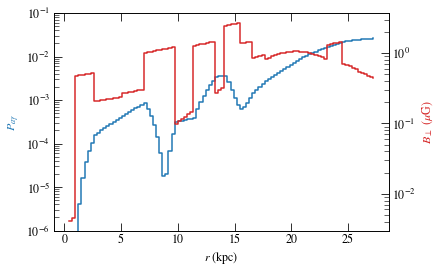

In [5]:
idx = 40
print ("Energy:", EGeV[idx], "GeV")

ax = plt.subplot(111)
ax.semilogy(ml.modules["GMF"].r, (prx[:,idx] + pry[:,idx])[::-1],
            drawstyle='steps')

plt.ylabel("$P_{a\gamma}$", color = plt.cm.tab10(0.))
plt.xlabel("$r$ (kpc)")
ax.set_ylim(1e-6,1e-1)

ax2 = ax.twinx()
ax2.semilogy(ml.modules["GMF"].r, ml.modules["GMF"].B[::-1],
             color = plt.cm.tab10(0.3),
             drawstyle ='steps')
plt.ylabel("$B_{\perp}$ ($\mu$G)", color = plt.cm.tab10(0.3))

Plot the total conversion probability as a function of energy:

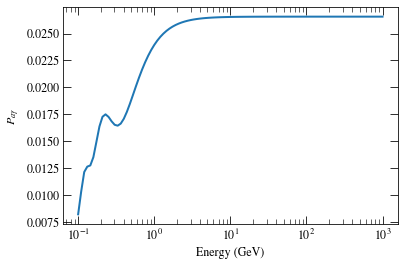

In [6]:
plt.semilogx(EGeV, px[0] + py[0], lw = 2)
plt.xlabel("Energy (GeV)")
plt.ylabel("$P_{a\gamma}$")
plt.savefig("pag_gmf.pdf")

## Sky map for mixing in the GMF

Next, we compute a full sky map using `healpy`. In each sky pixel, we calculate the photon-ALP conversion probability at one single energy (1 GeV).

First, we import healpy.

In [7]:
import healpy as hp
import time

And define the pixel grid:

In [8]:
NSIDE = 24
pix = np.arange(hp.nside2npix(NSIDE))  # get the pixels
ll, bb = hp.pixelfunc.pix2ang(NSIDE, pix, lonlat=True)  #  get the galactic coordinates for each pixel
print (ll.shape)

(6912,)


We loop over the coordinates and for each coordinate we re-initialize the `ModuleList` class 
and re-calculate the mixing probability.

In [9]:
EGeV = np.array([1.])  # energy
pgg = np.zeros((pix.shape[0],EGeV.shape[0]))  # array to store the results
src = Source(z=0.1, ra=0., dec=0.)  # some random source for initialization

# coupling and mass at which we want to calculate the conversion probability:
g = 0.3
m = 1.

t1 = time.time()
for i, l in enumerate(ll):
    src.l = l
    src.b = bb[i]
    ml = ModuleList(ALP(m=m,g=g),
                   src,
                   pin=pa_in,  # pure ALP beam
                   EGeV = EGeV)
    ml.add_propagation("GMF", 0, model='jansson12')  # add the propagation module
    px, py, pa = ml.run()  # run the code
    pgg[i] = px + py  # save the result

    if i < ll.size - 1:
        del ml
        
t2 = time.time()
print ("It took", t2-t1, "seconds")

/Users/manuelmeyer/Python/gammaALPs/gammaALPs/base/environs.py:981: RuntimeWarning: divide by zero encountered in double_scalars
  self._smax = np.amin([self.__zmax/np.abs(sb),


It took 53.90667915344238 seconds


Plot the full sky map using `healpy`'s Mollweide projection:

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


Text(0.03, 0.93, '$g_{a\\gamma} = 0.30\\times10^{-11}\\,\\mathrm{GeV}^{-1}$')

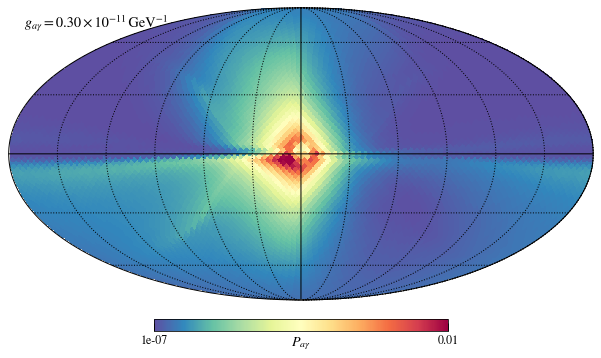

In [10]:
hpmap = hp.mollview(pgg[:,0], 
                    norm='linear',
                    title = '', 
                    unit= '$P_{a\gamma}$', 
                    min=1e-7,
                    max=1e-2, 
                    cmap = 'Spectral_r')
hp.graticule()
plt.annotate("$g_{{a\gamma}} = {0:.2f}\\times10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$".format(ml.alp.g),
            xy = (0.03,0.93), xycoords = 'axes fraction', fontsize = 'x-large', **effect)

We can also use `healpy` to calculate the power spectrum of $P_{a\gamma}$ in terms of an expansion into spherical components and multipole number $\ell$:

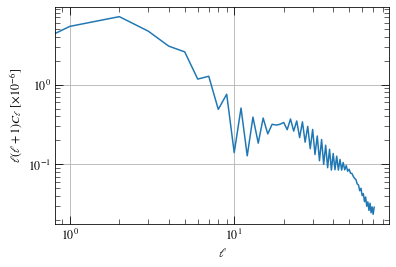

In [13]:
cl = hp.sphtfunc.anafast(pgg[:,0], gal_cut = 0.)
ell = np.arange(len(cl))

plt.loglog(ell, ell * (ell + 1) * cl * 1e6)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$ [$\\times10^{-6}$]")
plt.grid()